# Exercise: TKO_3120 Machine Learning and Pattern Recognition

# The problem
CIFAR-10 is a dataset consist of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The test images are composed of 1000 randomly selected images from each class. The training images contains 5,000 images from each class in random order. The goal of this execrisce, is to build an algorithm which takes a random image and classify it to one of the 10 classes with as high as possible accuracy.

# Import Packages
Import all the packages needed for this notebook in one cell

In [214]:
import numpy as np
import os
import platform
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sn


# Load the raw CIFAR-10 data

Donwnload the dataset from the zip file (cifar-10-batches-py) in moodle. Then unzip the file. 

In [215]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

In [216]:
def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [217]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

In [232]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cifar10'
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [219]:
# Smaller dataset on pc-comment out later
#train_size, test_size = 1000, 500
#X_train, y_train = X_train[0:train_size], y_train[0:train_size]
#X_test, y_test = X_test[0:test_size], y_test[0:test_size]


# Data Visualization

Show a few examples of training images from each class.

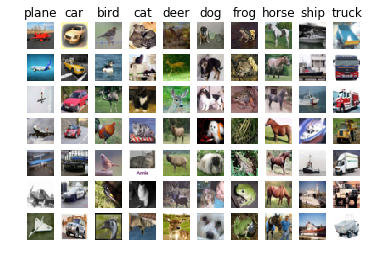

In [220]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Feature extraction



## 1- Color Mean and Standard Deviation
**Question (1 point):** 
Calculate the below mentioned color features for each image:

- Mean for each RGB color channel
- Standard Deviation (STD) for each RGB color channel


In [221]:
def get_rgb_mean(img):
    '''
    Numpy calculates the mean for each one of the color channels and stores it to a variable.
    Returns the resulting arrays in long format.
    '''
    r = np.mean(img[:,:,0])
    g = np.mean(img[:,:,1])
    b = np.mean(img[:,:,2])
    return np.asarray([r, g, b]).reshape(3,1)

def get_rgb_std(img):
    '''
    Numpy calculates the std for each one of the color channels and stores it to a variable.
    Returns the resulting arrays in long format.
    '''
    r = np.std(img[:,:,0])
    g = np.std(img[:,:,1])
    b = np.std(img[:,:,2])
    return np.asarray([r, g, b]).reshape(3,1)

## 2- Color Histograms
**Question (1 point):**

   Obtain histogram feature  (e.g. cv2.calcHist from OpenCV) for each of RGB channel with 8 bins per channel. 

In [222]:
def get_hist(img):
    '''
    Calculates the histogram like the code in the slides, appends three histograms to one array and flattens it
    '''
    arr = []
    for i, col in enumerate(['b', 'g', 'r']):
        img_copy = img.astype('float32')
        histr = cv2.calcHist([img_copy], [i], None, [8], [0, 256])
        arr.append(histr)
    arr = np.asarray(arr).reshape(24, 1)
    return(arr)

## 3- Local Binary Patterns (LBP)
**Question (1 point):**
Create Local Binary Pattern of each image 

    

In [223]:
def get_lbp(image):
    '''
    Calculates the LBP and reshapes it to long format before returning
    '''
    img = skimage.color.rgb2gray(image)
    patterns = local_binary_pattern(img, 8, 1)
    return patterns.reshape(32*32, 1)

In [224]:
def create_feature_vec(images):
    '''
    Takes in array of images and returns the generated matrix as Nx1054 array
    '''
    n = len(images)
    arr = []
    for i in range(n): #Loops image-vector
        img = images[i] 
        a, b, c, d = get_rgb_mean(img), get_rgb_std(img), get_hist(img), get_lbp(img) # Calling all the feature extraction functions
        j = np.concatenate((a, b, c, d)) # Concatenating all the feature vectors together
        arr.append(j) # Concatenating all the feature vectors to main feature vector which we call arr
    arr = np.asarray(arr) # Converting it into np array
    arr = arr.reshape((n, 1054)) # Reshaping from (1, N, 1054) to (N, 1054)
    return arr


Gather all features (Mean, std, HIS and LBP) into an input array X, and the image classes into an output array y. Standardize the
feature values in X. One standard way of doing it is zscore normalization, meaning that the feature values will have zero mean and unit variance.

In [225]:
feature_vector, test_vector = create_feature_vec(X_train), create_feature_vec(X_test) # Creating feature vectors
scaler = StandardScaler().fit(np.concatenate((feature_vector, test_vector), axis=0)) # Creating and fitting scaler with all inputs
feature_vector, test_vector = scaler.transform(feature_vector), scaler.transform(test_vector) # Creating scaled features

## PCA 
**Question (1 point):** 

Use PCA with 10 component to reduce dimension of the feature vector X.

In [226]:
pca = PCA(n_components=10).fit(np.concatenate((feature_vector, test_vector), axis=0)) # Creating the pca object and fitting the data
pca_features, pca_test = pca.transform(feature_vector), pca.transform(test_vector) # Transforming the data

In [227]:
sum(pca.explained_variance_ratio_[0:11]) # Components only explain ~13% of the variance. We are not probably going to have good results

0.125106762923574

# Build classifiers and estimate their performance

## 1- K-Nearest Neighbor (K-NN) 

In this exercise you will implement a K-NN classifier and understand the basic Image Classification pipeline and  cross-validation.

**Question (2 points):** 

Perform 5-fold cross validation to find the best value of k in range 1 to 30. For each possible value of k, run the k-nearest-neighbor algorithm num_folds times (5),   where in each case you use all but one of the folds as training data and the last fold as a validation set.                   



In [298]:
kf = KFold(n_splits = 5, random_state=1, shuffle=False) #Creating crossvalidation object
scores = [] 
for k in range(1, 31): # Looping k values from 1 to 30
    knn = KNeighborsClassifier(n_neighbors=k) # Creating the classifier
    score = 0 # Setting score to 0 for this k value
    for train_index, test_index in kf.split(pca_features): # Looping the kfolded objects
        kX_train, kX_test = pca_features[train_index], pca_features[test_index] # Getting the train and test sets from crossvalidation
        ky_train, ky_test = y_train[train_index], y_train[test_index]
        knn.fit(kX_train, ky_train) # Fitting the knn classifier
        score =+ knn.score(kX_test, ky_test) # Summing all 5 scores together
    scores.append(np.mean(score)) # Appending mean of 5 scores to the score array which we will plot next        
    

**Question (1 point):** 

- Plot the Cross-validated accuracy based on the different value of k

Maximum of scores was: 0.2897 and the k-value for it is: 28


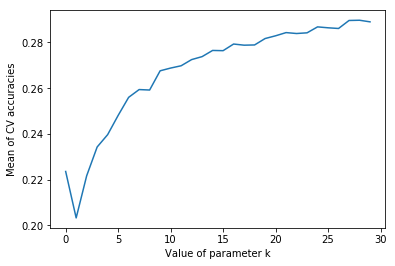

In [300]:
print(f"Maximum of scores was: {max(scores)} and the k-value for it is: {np.argmax(scores)}")
plt.plot(scores)
plt.ylabel("Mean of CV accuracies")
plt.xlabel("Value of parameter k")
plt.show()

**Questions (2 points):** 
    
- Based on the cross-validation results above, choose the best value for k,   

- Retrain the classifier using all the training data, and test it on the test data. 

- What is the accuracy value for the test data?

In [301]:
knn = KNeighborsClassifier(n_neighbors=np.argmax(scores)) # Making the model with best crossvalidated parameter
knn.fit(pca_features, y_train) # Fitting the model
knn.score(pca_test, y_test) # Printing the accuracy score

0.2874

## 2- Logistic Regression (LR)


In this exercise you will implement a LR classifier.

**Question (2 points):** 

- Create and train the Logistic Regression model
- Calculate the accuracy and the confusion matrix on test dataset

In [274]:
# Creating the model
multinom_model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto', max_iter=4000, verbose=2).fit(feature_vector, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


Accuracy: 0.3296
              precision    recall  f1-score   support

           0       0.42      0.43      0.43       996
           1       0.36      0.34      0.35      1059
           2       0.24      0.28      0.26       868
           3       0.20      0.24      0.22       861
           4       0.28      0.30      0.29       922
           5       0.25      0.26      0.25       930
           6       0.38      0.35      0.36      1072
           7       0.35      0.32      0.33      1077
           8       0.44      0.39      0.41      1140
           9       0.37      0.35      0.36      1075

   micro avg       0.33      0.33      0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.34      0.33      0.33     10000



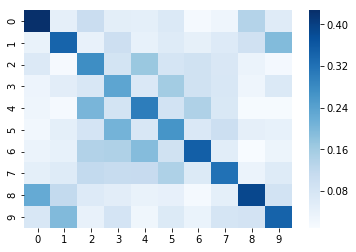

In [286]:
print(f'Accuracy: {multinom_model.score(test_vector, y_test)}') #Pringting the accuracy
print(classification_report(pred, y_test))
pred = multinom_model.predict(test_vector) # Creating predicted values for confusion matrix
cf_matrix = confusion_matrix(pred, y_test) # creating confusion matrix
cf_matrix = cf_matrix / cf_matrix.astype(np.float).sum(axis=1) # Normalising the confusion matrix to percentages
sn.heatmap(cf_matrix, annot_kws={"size": 16}, cmap=plt.cm.Blues) # plotting the confusion matrix

## 3- Multilayer perceptron 
In this exercise you will develop a neural network with one hidden layer to perform classification.

Use:

- solver for weight optimization: stochastic gradient-based optimizer ('sgd')
- activation function for the hidden layer: rectified linear unit function ('relu')
- Early stop

**Questions (3 points):** 
- What is the prediction accuracy for the test data?
-  To evaluate the MLP model, calculate the metrics such as a confusion matrix, precision, recall, and f1 score. 
-  Show the predicted results (classification lable) on 5 random example of test dataset.
- Show 5 random of wrong predictions

In [ ]:
x_tra, x_tes, y_tra, y_tes = train_test_split(feature_vector, y_train, test_size=0.2, random_state=0)
scores = np.zeros((50, 50))
for j in tqdm(range(1, 51)):
    for i in range(1, 51):
        if i * 10 + j * 10 > 2 * 1054:
            pass
        mlp_model = MLPClassifier(solver='sgd', hidden_layer_sizes=(500, 200),
                          activation='relu', early_stopping=True).fit(x_tra, y_tra) #Training the MLP-model
        scores[i-1][j-1] = mlp.score()


In [261]:
mlp_model = MLPClassifier(solver='sgd', hidden_layer_sizes=(500, 200),
                          activation='relu', early_stopping=True).fit(feature_vector, y_train) #Training the MLP-model
print(mlp_model.score(test_vector, y_test))

0.3563


Prediction accuracy: 0.3563
              precision    recall  f1-score   support

           0       0.43      0.43      0.43       997
           1       0.43      0.42      0.42      1021
           2       0.23      0.26      0.25       908
           3       0.21      0.24      0.22       884
           4       0.27      0.30      0.28       904
           5       0.28      0.29      0.28       961
           6       0.41      0.37      0.39      1111
           7       0.37      0.37      0.37      1011
           8       0.49      0.45      0.47      1094
           9       0.44      0.40      0.42      1109

   micro avg       0.36      0.36      0.36     10000
   macro avg       0.36      0.35      0.35     10000
weighted avg       0.36      0.36      0.36     10000



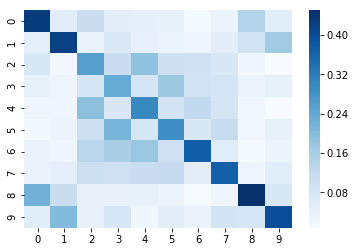

In [302]:
#Code from https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
print(f'Prediction accuracy: {mlp_model.score(test_vector, y_test)}') # Printing model accuracy
pred = mlp_model.predict(test_vector) # Making the prediction vector for future use
cf_matrix = confusion_matrix(pred, y_test) # Making the confusion matrix
cf_matrix = cf_matrix / cf_matrix.astype(np.float).sum(axis=1) # Normalising the values of confusion matrix to percentages
sn.heatmap(cf_matrix, annot_kws={"size": 16}, cmap=plt.cm.Blues) # Drawing the heatmap from confusion matrix
print(classification_report(pred, y_test)) #Printing precision, recall and f1 scores

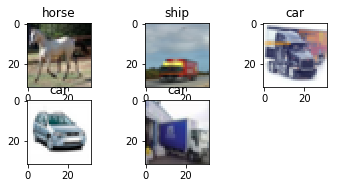

In [291]:
randoms = np.random.choice(range(len(X_test)), size=5, replace=False) #Selecting index of 5 random predictions
for i, r in enumerate(randoms): # Enumerating the random predictions, i for pictures, r for randomised values
    plt.subplot(330 + 1 + i) # Creating the subplot
    plt.title(f"{classes[pred[r]]}") # Making a title for picture
    plt.imshow(X_test[r].astype('uint8')) # Plotting the randomly selected picture

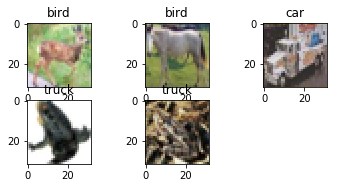

In [303]:
false_imgs = X_test[np.where(y_test != pred)] # Selecting the images where our prediction is wrong
wrong_preds = pred[np.where(y_test != pred)] # Creating a vector for falsely predicted images
randoms = np.random.choice(range(len(false_imgs)), size=5, replace=False) # Selecting 5 random indexes out of those pics
for i, r in enumerate(randoms): # Enumerating them and continuing the same as in other picture
    plt.subplot(330 + 1 + i)
    plt.title(f"{classes[wrong_preds[r]]}")
    plt.imshow(false_imgs[r].astype('uint8'))
plt.show()